## Vectorizing Operations

The first element on our checklist was to examine data types.

If we have downcast all our data, what should we do next?

### What is vectorization?
Vectorization is doing operations on sets of values instead of individual values.

Example of a numpy function that is "vectorized":

In [1]:
import numpy as np

In [2]:
%timeit np.sum(np.arange(100000))

96.2 µs ± 9.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Compare this to a function that is not vectorized:

In [3]:
def sum_test():    
    total = 0
    for i in np.arange(100000):
        total += i
    return total

%timeit sum_test

21 ns ± 1.8 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


Orders of magnitude faster.

Often it feels easier to use for loops because they are easier to conceive and write. Taking time to vectorize an operation can help speed up code significantly, however.

Another example of an operation we already vectorized:

To look at crop rotation, we had to assign values to an array based on the values of other arrays.

The non-vectorized version:

In [4]:
y16 = np.random.randint(0,2,size=1000000).reshape(1000,1000)
y17 = np.random.randint(0,2,size=1000000).reshape(1000,1000)

In [5]:
def non_vect():
    rotate = np.zeros([1000,1000])
    for i in range(1000):
        for j in range(1000):
            rotate[i,j] = (1-y16[i,j])*y17[i,j]
    return rotate

%timeit non_vect()

654 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The vectorized version:

In [6]:
(1-y16)*y17

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [7]:
%timeit (1-y16)*y17

3.76 ms ± 509 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Which is quite a bit of a speed improvement.

Another useful aspect of vectorization is that `numpy` will __broadcast__ arrays together:

In [8]:
import numpy as np
sample = np.random.normal(loc=[4., 20.], scale=[1., 3.5],
                           size=(10, 2))

In [9]:
sample

array([[ 3.22583888, 12.80841919],
       [ 3.06673373, 24.35108675],
       [ 3.91665864, 20.30968926],
       [ 4.99287654, 17.67844944],
       [ 3.17975809, 15.09755365],
       [ 2.03942398, 19.63728082],
       [ 4.41554203, 20.41823852],
       [ 3.48653573, 22.69152129],
       [ 4.95747064, 21.40917424],
       [ 4.44111039, 17.11444411]])

In [10]:
sample.mean(axis=0)

array([ 3.77219487, 19.15158573])

In [11]:
mu = sample.mean(axis=0)

In [12]:
mu

array([ 3.77219487, 19.15158573])

How could we demean this?

In [13]:
sample - mu

array([[-0.54635598, -6.34316654],
       [-0.70546113,  5.19950102],
       [ 0.14446377,  1.15810353],
       [ 1.22068167, -1.47313629],
       [-0.59243677, -4.05403208],
       [-1.73277089,  0.48569509],
       [ 0.64334717,  1.26665279],
       [-0.28565914,  3.53993557],
       [ 1.18527578,  2.25758851],
       [ 0.66891553, -2.03714161]])

Why did this work? These are not compatible arrays!

When an operation is done between two mismatched arrays, `numpy` first checks whether the right most dimension matches. If they match, it broadcasts (essentially repeats) the array so that it becomes the same shape as the other array.

In this case, it found an array that was (10,2) and (,2), so it simply repeated the mean 10 times so that it was (10,2). Then it did an element by element subtraction.

This could be used to standardize arrays:

In [14]:
std = sample.std(axis=0)

In [15]:
(sample -mu)/std

array([[-0.6105236 , -1.90531718],
       [-0.78831511,  1.56179072],
       [ 0.16143055,  0.34786325],
       [ 1.36404652, -0.44249065],
       [-0.66201642, -1.21772256],
       [-1.93627884,  0.14588979],
       [ 0.71890607,  0.38046854],
       [-0.31920882,  1.06330174],
       [ 1.32448232,  0.67811907],
       [ 0.74747734, -0.61190273]])

You can very easily do this with pandas dataframes too:

In [16]:
import pandas as pd
sample_df = pd.DataFrame(sample)

In [17]:
(sample_df-sample_df.mean())/sample_df.std()

,0,1
0,-0.579194,-1.807543
1,-0.747861,1.481645
2,0.153146,0.330012
3,1.294048,-0.419783
4,-0.628044,-1.155233
5,-1.836915,0.138403
6,0.682014,0.360944
7,-0.302828,1.008737
8,1.256514,0.643320
9,0.709119,-0.580502


### An aside: data stacking and pivoting with pandas
We have not yet mentioned all of the ways to do pivot tables and data transformations in pandas.

Let' start with the "stack" function

In [18]:
import pandas as pd

df = pd.read_csv("panel_example.csv")

df = df.set_index(['i','t'])

Dataframes can use multi-level indices which can be useful:

In [19]:
df['value2'] = df['value'] +2

In [20]:
df_wide = df['value'].unstack()

df_wide

t,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
0,4.688026,5.522693,3.794489,3.964962,2.411890,3.411730,5.471047,2.224358,3.014295,3.628636
1,20.763822,21.364728,16.473118,22.906417,20.685359,23.985350,17.449606,24.309989,19.684198,19.468067
2,13.345220,13.759424,15.433405,7.599836,12.815756,9.567005,13.707837,5.037831,9.862822,17.529517
3,2.874506,17.500661,21.603200,3.615383,12.067565,12.347808,6.555567,7.524997,-2.819713,-12.429077


So calling `unstack` will automatically use the outermost index. Setting the level will change this behavior.

In [21]:
df.unstack(level=0)

value                                     value2                        \
i         0          1          2          3         0          1          2   
t                                                                              
0  4.688026  20.763822  13.345220   2.874506  6.688026  22.763822  15.345220   
1  5.522693  21.364728  13.759424  17.500661  7.522693  23.364728  15.759424   
2  3.794489  16.473118  15.433405  21.603200  5.794489  18.473118  17.433405   
3  3.964962  22.906417   7.599836   3.615383  5.964962  24.906417   9.599836   
4  2.411890  20.685359  12.815756  12.067565  4.411890  22.685359  14.815756   
5  3.411730  23.985350   9.567005  12.347808  5.411730  25.985350  11.567005   
6  5.471047  17.449606  13.707837   6.555567  7.471047  19.449606  15.707837   
7  2.224358  24.309989   5.037831   7.524997  4.224358  26.309989   7.037831   
8  3.014295  19.684198   9.862822  -2.819713  5.014295  21.684198  11.862822   
9  3.628636  19.468067  17.529517 -12.429077  5.628636  21.468067  19.529517   

              
i          3  
t             
0   4.874506  
1  19.500661  
2  23.603200  
3   5.615383  
4  14.067565  
5  14.347808  
6   8.555567  
7   9.524997  
8  -0.819713  
9 -10.429077

A fancier version of this is the `pivot_table` function, which can handle statistics.

In [22]:
pd.pivot(df.reset_index(),columns="i",values='value2',index="t")

i,0,1,2,3
t,,,,
0,6.688026,22.763822,15.345220,4.874506
1,7.522693,23.364728,15.759424,19.500661
2,5.794489,18.473118,17.433405,23.603200
3,5.964962,24.906417,9.599836,5.615383
4,4.411890,22.685359,14.815756,14.067565
5,5.411730,25.985350,11.567005,14.347808
6,7.471047,19.449606,15.707837,8.555567
7,4.224358,26.309989,7.037831,9.524997
8,5.014295,21.684198,11.862822,-0.819713


Cow data example

In [24]:
data_dir="C:/Users/jhtchns2/Box/ACE 592 SAE - Spring 2023/Class_Examples/3_Numeric/"
d = pd.read_csv(data_dir + "naab_example.csv")

# Make an id
d['id'] = d['breed'] + d['country_of_origin'] + d['sire_code'].astype(str)

In [25]:
pd.pivot_table(d,index='id',columns=['eval_period'],values='pta_milk')

eval_period,2000-02,2000-05,2000-08,2000-11,2001-02,2001-05,2001-08,2001-11,2002-02,2002-05,...,2017-08,2017-12,2018-04,2018-08,2018-12,2019-04,2019-08,2019-12,2020-04,2020-08
id,,,,,,,,,,,,,,,,,,,,,
AY84010863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1054.142857,1054.142857,975.038847,956.241855,954.899273,932.919628
AY8401881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AY8401885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,891.235589,879.487469,768.072290,NaN
AY8401886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1256.993734,1282.056391,1300.070175,1318.867168,1410.502506,1246.028822,1040.828321,1115.233083,1093.371038,840.605119
AY8401887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WWUSA9334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WWUSA9335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,970.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WWUSA9336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using an index that applies to more than one cow means we can specify an "aggfunc" (aggregation function):

In [26]:
breed_avgs = pd.pivot_table(d,index='breed',columns=['eval_period'],values='pta_milk',aggfunc="mean")

breed_avgs.T

breed,AY,BS,GU,HO,JE,MI,MO,MS,NR,RE,SM,SR,WW
eval_period,,,,,,,,,,,,,
2000-02,1078.620000,1314.545455,1296.542857,1563.768177,1268.117647,NaN,NaN,1087.714286,NaN,NaN,NaN,NaN,1413.426667
2000-05,1136.027027,1362.111111,1434.968750,1634.062262,1370.114583,NaN,NaN,1185.714286,NaN,NaN,NaN,NaN,1353.507463
2000-08,1164.090909,1373.444444,1536.958333,1646.885486,1386.071429,NaN,NaN,1161.285714,NaN,NaN,NaN,NaN,652.254545
2000-11,1209.303030,1466.000000,1519.043478,1677.508021,1394.630000,NaN,NaN,1063.142857,NaN,NaN,NaN,NaN,685.795918
2001-02,1211.911765,1466.571429,1617.818182,1714.026560,1439.809524,NaN,NaN,1167.375000,NaN,NaN,NaN,NaN,681.295455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04,1508.389523,2286.680058,1585.225705,3251.635882,2217.836529,NaN,8.5,703.710097,1748.428571,991.800000,NaN,1194.785714,245.571429
2019-08,1476.929166,2296.416700,1539.566514,3265.445018,2227.282702,NaN,-39.5,783.097222,1783.428571,961.346154,NaN,1295.428571,-66.000000
2019-12,1467.566768,2324.473739,1525.470566,3296.811459,2297.008547,-1670.0,-6.0,785.478175,1752.625000,1040.260870,-480.0,1278.285714,130.000000


<AxesSubplot: xlabel='eval_period'>

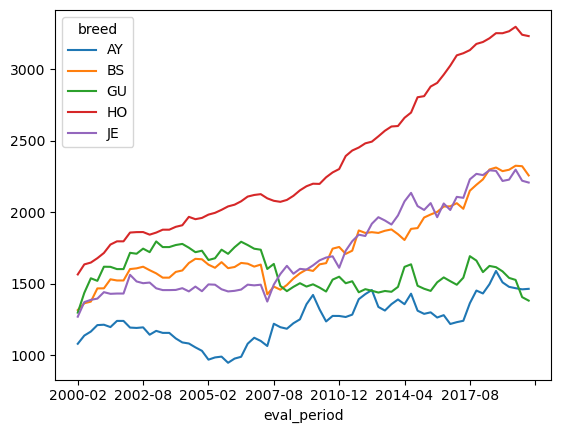

In [27]:
breed_avgs.T.iloc[:,:5].plot()

Most "improvement" in milk yield has happened with "HO" (Holstein) cows.